In [1]:
from src.models.jelly import ShallowCSNN
from src.utils.dataloaders import create_dataloaders
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics import F1Score, AUROC, Recall, Specificity, Accuracy
import torch
from src.utils.parameters import instantiate_cls
from torchvision import transforms
from spikingjelly.activation_based import neuron, functional
from src.datasets.custom import CustomImageFolder
from torch.utils.data import DataLoader

In [24]:
train_dataset = instantiate_cls('torchvision.datasets', 'FashionMNIST', {"root" : './data', "train" : True, "download": True})
test_dataset = instantiate_cls('torchvision.datasets', 'FashionMNIST', {"root" : './data', "train" : False, "download": True})

train_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
])
test_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = DataLoader(train_dataset, batch_size=32,
                              pin_memory=True, num_workers=4)

In [25]:
model = ShallowCSNN((1, 28, 28), 10, 5)
device = 'cuda'
model.to(device)

ShallowCSNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (6): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False, st

In [26]:
sample = next(iter(train_loader))
image = sample[0][0]

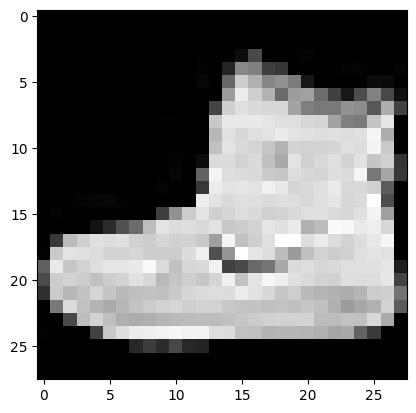

In [27]:
import matplotlib.pyplot as plt

plt.imshow(image[0], cmap='gray')
plt.show()

In [28]:
output = model(image.to('cuda'))
output

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [29]:
from torch import nn
from spikingjelly.activation_based import neuron, functional, surrogate, layer

In [30]:

class CSNN(nn.Module):
    def __init__(self, T: int, channels: int, use_cupy=False):
        super().__init__()
        self.T = T

        self.conv_fc = nn.Sequential(
        layer.Conv2d(1, channels, kernel_size=3, padding=1, bias=False),
        layer.BatchNorm2d(channels),
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        layer.MaxPool2d(2, 2),  # 14 * 14

        layer.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
        layer.BatchNorm2d(channels),
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        layer.MaxPool2d(2, 2),  # 7 * 7

        layer.Flatten(),
        layer.Linear(channels * 7 * 7, channels * 4 * 4, bias=False),
        neuron.IFNode(surrogate_function=surrogate.ATan()),

        layer.Linear(channels * 4 * 4, 10, bias=False),
        neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

        if use_cupy:
            functional.set_backend(self, backend='cupy')

    def forward(self, x: torch.Tensor):
        # x.shape = [N, C, H, W]
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr

In [31]:
model = CSNN(4, 16)
model.to('cuda')

CSNN(
  (conv_fc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=m)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (6): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (8): Flatten(start_dim=1, end_dim=-1, st

In [32]:
preds = model(sample[0].to('cuda')).cpu()
onehot = F.one_hot(sample[1], 10).cpu()

In [ ]:
loss = torch.nn.MSELoss()
acc = Accuracy(task='multiclass', num_classes=10)
acc(preds, onehot)

tensor(0.9000)

: 

In [4]:
from torch import nn
from torchsummary import summary

In [ ]:

class MNET10(nn.Module):
    def __init__(self, n_input=3, n_output=4, in_size=224):
        super(MNET10, self).__init__()

        self.n_input = n_input
        self.n_output = n_output
        self.in_size = in_size
        k_size = 3

        self.block1 = nn.Sequential(
            nn.Conv2d(n_input, 16, k_size),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, k_size),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, k_size),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, k_size),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, k_size),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, k_size),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, k_size),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, k_size),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10 * 10 * 128, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_output)
        )
        
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.block1(x))
        x = self.pool(self.block2(x))
        x = self.pool(self.block3(x))
        x = self.pool(self.block4(x))
        x = self.classifier(x)
        return x

In [6]:
model = MNET10(1, 4, 224)
model.to('cuda')

MNET10(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leak

In [7]:
summary(model, (1, 224, 224))

KeyboardInterrupt: 

In [ ]:
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
       BatchNorm2d-2         [-1, 16, 222, 222]              32
         LeakyReLU-3         [-1, 16, 222, 222]               0
            Conv2d-4         [-1, 16, 220, 220]           2,320
       BatchNorm2d-5         [-1, 16, 220, 220]              32
         LeakyReLU-6         [-1, 16, 220, 220]               0
         MaxPool2d-7         [-1, 16, 110, 110]               0
            Conv2d-8         [-1, 32, 108, 108]           4,640
       BatchNorm2d-9         [-1, 32, 108, 108]              64
        LeakyReLU-10         [-1, 32, 108, 108]               0
           Conv2d-11         [-1, 32, 106, 106]           9,248
      BatchNorm2d-12         [-1, 32, 106, 106]              64
        LeakyReLU-13         [-1, 32, 106, 106]               0
        MaxPool2d-14           [-1, 32,

: 

In [2]:
from src.datasets.custom import CustomImageFolder

dataset = CustomImageFolder('/mnt/d/datasets/vindr-mammo/data/raw', 224, True, 'all')

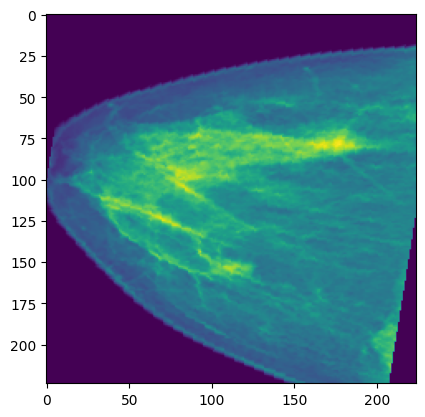

In [10]:
for x, y in dataset:
    break

import matplotlib.pyplot as plt

plt.imshow(x[0])
plt.show()